In [50]:
import pandas as pd
import xgboost as xgb
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV
import matplotlib.pyplot as plt

In [51]:
train = pd.read_csv('data/datasets/ais_train.csv', sep='|')
train['time'] = pd.to_datetime(train['time'])
train.info()
missing_values = train.isnull().sum()
print("Number of missing values in each column:\n", missing_values)

train.head()

test = pd.read_csv('data/datasets/ais_test.csv', sep=',')
test['time'] = pd.to_datetime(test['time'])
test.head()

vessels = pd.read_csv('data/datasets/vessels.csv', sep='|')
vessels.head()

ports = pd.read_csv('data/datasets/ports.csv', sep='|')
ports.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1522065 entries, 0 to 1522064
Data columns (total 11 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   time       1522065 non-null  datetime64[ns]
 1   cog        1522065 non-null  float64       
 2   sog        1522065 non-null  float64       
 3   rot        1522065 non-null  int64         
 4   heading    1522065 non-null  int64         
 5   navstat    1522065 non-null  int64         
 6   etaRaw     1522065 non-null  object        
 7   latitude   1522065 non-null  float64       
 8   longitude  1522065 non-null  float64       
 9   vesselId   1522065 non-null  object        
 10  portId     1520450 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(3), object(3)
memory usage: 127.7+ MB
Number of missing values in each column:
 time            0
cog             0
sog             0
rot             0
heading         0
navstat         0
etaRaw          0

,portId,name,portLocation,longitude,latitude,UN_LOCODE,countryName,ISO
0,61d36ed80a1807568ff9a064,Port of Algiers,Algiers,3.067222,36.773611,DZALG,Algeria,DZ
1,61d36ed80a1807568ff9a065,Port of Annaba,Annaba,7.772500,36.900556,DZAAE,Algeria,DZ
2,61d36edf0a1807568ff9a070,Port of Oran,Oran,-0.639722,35.712222,DZORN,Algeria,DZ
3,61d36ee00a1807568ff9a072,Port of Skikda,Skikda,6.905833,36.887500,DZSKI,Algeria,DZ
4,61d36ee10a1807568ff9a074,Port of Pago-Pago,Pago-Pago,-170.690556,-14.274167,ASPPG,American Samoa,AS


In [52]:
train = train.dropna(subset=['portId'])
print(train.shape)
# Verify the result by checking the count of missing values
print("Number of missing values in each column after dropping rows with NaN in 'portId':")
print(train.isna().sum())

(1520450, 11)
Number of missing values in each column after dropping rows with NaN in 'portId':
time         0
cog          0
sog          0
rot          0
heading      0
navstat      0
etaRaw       0
latitude     0
longitude    0
vesselId     0
portId       0
dtype: int64


In [53]:
schedules = pd.read_csv('data/datasets/schedules_to_may_2024.csv', sep='|')

In [54]:
port_id_mapping = {port_id: idx for idx, port_id in enumerate(train['portId'].unique())}
train['portId'] = train['portId'].map(port_id_mapping)
ports['portId'] = ports['portId'].map(port_id_mapping)
schedules['portId'] = schedules['portId'].map(port_id_mapping)

vessel_id_mapping = {vessel_id: idx for idx, vessel_id in enumerate(train['vesselId'].unique())}
train['vesselId'] = train['vesselId'].map(vessel_id_mapping)
vessels['vesselId'] = vessels['vesselId'].map(vessel_id_mapping)
test['vesselId'] = test['vesselId'].map(vessel_id_mapping)
schedules['vesselId'] = schedules['vesselId'].map(vessel_id_mapping)


shipping_line_id_mapping = {shipping_line_id: idx for idx, shipping_line_id in enumerate(vessels['shippingLineId'].unique())}
vessels['shippingLineId'] = vessels['shippingLineId'].map(shipping_line_id_mapping)
schedules['shippingLineId'] = schedules['shippingLineId'].map(shipping_line_id_mapping)

In [55]:
import pytz
schedules['sailingDate'] = pd.to_datetime(schedules['sailingDate'], errors='coerce')
schedules['arrivalDate'] = pd.to_datetime(schedules['arrivalDate'], errors='coerce')

# Convert sailingDate and arrivalDate to a different timezone, such as CET (Central European Time)
# Convert datetime columns to timezone-naive format by removing timezone info
schedules['sailingDate'] = schedules['sailingDate'].dt.tz_convert(None)
schedules['arrivalDate'] = schedules['arrivalDate'].dt.tz_convert(None)


schedules.head()


,vesselId,shippingLineId,shippingLineName,arrivalDate,sailingDate,portName,portId,portLatitude,portLongitude
0,71.0,5,Wallenius Wilhelmsen Ocean,2023-10-02,2023-10-03,Port of Brunswick,121.0,31.140556,-81.496667
1,71.0,5,Wallenius Wilhelmsen Ocean,2023-10-27,2023-10-27,Port of Southampton,56.0,50.902500,-1.428889
2,71.0,5,Wallenius Wilhelmsen Ocean,2023-10-19,2023-10-20,Port of Bremerhaven,38.0,53.563611,8.554722
3,71.0,5,Wallenius Wilhelmsen Ocean,2023-10-09,2023-10-10,Port of New York,159.0,40.688333,-74.028611
4,71.0,5,Wallenius Wilhelmsen Ocean,2023-09-25,2023-09-26,Manzanillo International Terminal,364.0,9.372370,-79.879790


In [56]:
vessels.head()

,shippingLineId,vesselId,CEU,DWT,GT,NT,vesselType,breadth,depth,draft,enginePower,freshWater,fuel,homePort,length,maxHeight,maxSpeed,maxWidth,rampCapacity,yearBuilt
0,0,599.0,6500,21200.0,58684,17606.0,83.0,32.0,22.20,NaN,0.0,NaN,NaN,OSLO,199.00,5.0,18.6,15.2,150.0,2000
1,1,64.0,4902,12325.0,46800,NaN,83.0,31.0,NaN,NaN,14220.0,NaN,NaN,MONROVIA,182.00,NaN,NaN,NaN,NaN,2006
2,2,640.0,5000,13059.0,46800,NaN,83.0,31.0,NaN,NaN,14220.0,NaN,NaN,SAINT JOHN'S,182.00,NaN,NaN,NaN,NaN,2010
3,3,254.0,4200,12588.0,39362,NaN,83.0,28.0,NaN,NaN,11060.0,NaN,NaN,NaN,167.00,NaN,NaN,NaN,NaN,2011
4,4,67.0,7450,21052.0,75528,24391.0,83.0,37.2,22.23,NaN,13140.0,491.47,3236.78,Panama,199.98,NaN,NaN,NaN,NaN,2018


In [57]:


train = train.merge(ports[['portId', 'latitude', 'longitude']], how='left', left_on='portId', right_on='portId', suffixes=('', '_port'))
train.head()

,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId,latitude_port,longitude_port
0,2024-01-01 00:00:25,284.0,0.7,0,88,0,01-09 23:00,-34.74370,-57.85130,0,0,-33.5875,-71.618889
1,2024-01-01 00:00:36,109.6,0.0,-6,347,1,12-29 20:00,8.89440,-79.47939,1,1,8.9670,-79.533000
2,2024-01-01 00:01:45,111.0,11.0,0,112,0,01-02 09:00,39.19065,-76.47567,2,2,39.2325,-76.558889
3,2024-01-01 00:03:11,96.4,0.0,0,142,1,12-31 20:00,-34.41189,151.02067,3,3,-34.4625,150.899444
4,2024-01-01 00:03:51,214.0,19.7,0,215,0,01-25 12:00,35.88379,-5.91636,4,4,35.7830,-5.817000


In [58]:
train = train.merge(vessels[['vesselId', 'length', 'shippingLineId', 'breadth', 'GT']], on='vesselId', how='left')
train['vessel_deep_sea'] = np.where(train['length'] > 200, 1, 0)

num_maxSpeed_nan = train['breadth'].isna().sum()
print(f"Number of NaN values in maxSpeed: {num_maxSpeed_nan}")
train.head()

Number of NaN values in maxSpeed: 14949


,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId,latitude_port,longitude_port,length,shippingLineId,breadth,GT,vessel_deep_sea
0,2024-01-01 00:00:25,284.0,0.7,0,88,0,01-09 23:00,-34.74370,-57.85130,0,0,-33.5875,-71.618889,199.00,9,32.00,57718,0
1,2024-01-01 00:00:36,109.6,0.0,-6,347,1,12-29 20:00,8.89440,-79.47939,1,1,8.9670,-79.533000,199.97,6,32.26,59583,0
2,2024-01-01 00:01:45,111.0,11.0,0,112,0,01-02 09:00,39.19065,-76.47567,2,2,39.2325,-76.558889,199.00,14,32.00,59217,0
3,2024-01-01 00:03:11,96.4,0.0,0,142,1,12-31 20:00,-34.41189,151.02067,3,3,-34.4625,150.899444,199.00,5,32.00,55598,0
4,2024-01-01 00:03:51,214.0,19.7,0,215,0,01-25 12:00,35.88379,-5.91636,4,4,35.7830,-5.817000,199.95,6,32.20,58939,0


In [59]:
# Calculate the mean breadth for shipping line 5
mean_breadth_shipping_line_5 = train[train['shippingLineId'] == 5]['breadth'].mean()

# Impute missing breadth with the calculated mean
train.loc[train['shippingLineId'] == 5, 'breadth'] = train.loc[train['shippingLineId'] == 5, 'breadth'].fillna(mean_breadth_shipping_line_5)

# Verify if the missing values were filled
missing_count_after_imputation = train['breadth'].isnull().sum()
print(f"Missing Breadth values after imputation: {missing_count_after_imputation}")


Missing Breadth values after imputation: 0


In [60]:
train.info()
missing_values = train.isnull().sum()
print("Number of missing values in each column:\n", missing_values)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1520450 entries, 0 to 1520449
Data columns (total 18 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   time             1520450 non-null  datetime64[ns]
 1   cog              1520450 non-null  float64       
 2   sog              1520450 non-null  float64       
 3   rot              1520450 non-null  int64         
 4   heading          1520450 non-null  int64         
 5   navstat          1520450 non-null  int64         
 6   etaRaw           1520450 non-null  object        
 7   latitude         1520450 non-null  float64       
 8   longitude        1520450 non-null  float64       
 9   vesselId         1520450 non-null  int64         
 10  portId           1520450 non-null  int64         
 11  latitude_port    1520450 non-null  float64       
 12  longitude_port   1520450 non-null  float64       
 13  length           1520450 non-null  float64       
 14  sh


Minimum required date:
2024-05-07 23:59:08


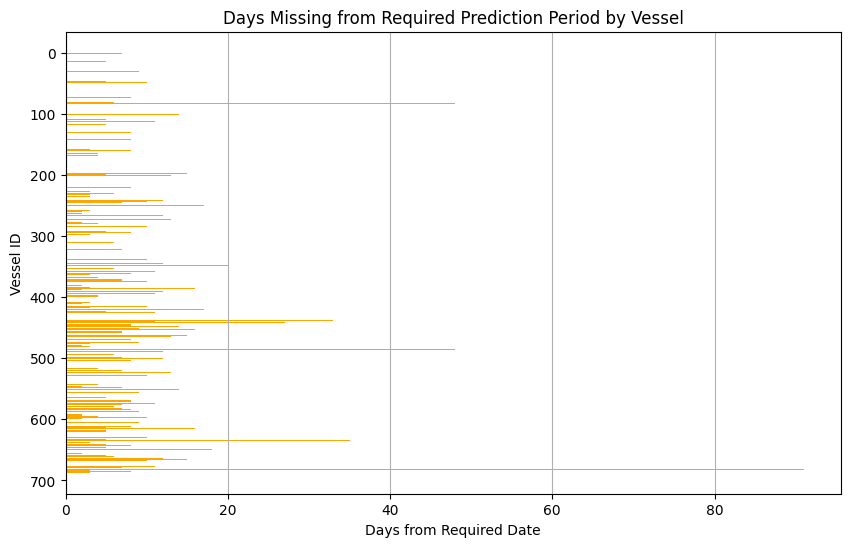

In [61]:
df_days_before_prediction = train.copy()
# Ensure 'time' column is in datetime format
df_days_before_prediction['time'] = pd.to_datetime(df_days_before_prediction['time'])


# Specify the year to append
current_year = 2024  # Change to the desired year

# Modify etaRaw to include the year
df_days_before_prediction['etaRaw'] = df_days_before_prediction['etaRaw'].apply(lambda x: f"{current_year}-{x}")


# Convert 'etaRaw' column to datetime
df_days_before_prediction['etaRaw'] = pd.to_datetime(df_days_before_prediction['etaRaw'], format='%Y-%m-%d %H:%M', errors='coerce')

# Define the start of the prediction period and calculate minimum required date
prediction_start_date = df_days_before_prediction['time'].max()
days_before_start = 0  # Set to the number of days you want before the start date
min_required_date = prediction_start_date 

# Get the last recorded date for each vessel along with `etaRaw`
vessel_last_dates = df_days_before_prediction.groupby('vesselId').agg({'time': 'max', 'etaRaw': 'last'}).reset_index()
vessel_last_dates.rename(columns={'time': 'last_train_time'}, inplace=True)

# Check the minimum required date
print("\nMinimum required date:")
print(min_required_date)

# Add a new column to indicate if etaRaw is before the minimum required date
vessel_last_dates['etaRaw_before_required'] = vessel_last_dates['etaRaw'] < min_required_date

# Calculate days missing from the required date
vessel_last_dates['days_from_required'] = (min_required_date - vessel_last_dates['last_train_time']).dt.days

# Add a new column to indicate if the data is before the required date
vessel_last_dates['before_required_date'] = vessel_last_dates['days_from_required'] > 1

# Separate vessels with incomplete data
vessels_with_incomplete_data = vessel_last_dates[vessel_last_dates['before_required_date']]

# Plot vessels with incomplete data
plt.figure(figsize=(10, 6))
plt.barh(vessels_with_incomplete_data['vesselId'], vessels_with_incomplete_data['days_from_required'], color='orange')
plt.xlabel('Days from Required Date')
plt.ylabel('Vessel ID')
plt.title('Days Missing from Required Prediction Period by Vessel')
plt.gca().invert_yaxis()  # Invert y-axis to have the vessel with the most missing days on top
plt.grid(axis='x')  # Add gridlines for better readability
plt.show()



In [62]:
# Define the minimum required date for predictions in the test set
min_required_date = test['time'].min() - pd.Timedelta(days=5)  # 5 days before the earliest test date
print(f"Minimum required date for predictions: {min_required_date}")

# Filter the schedules DataFrame based on the required date
schedules_filtered = schedules[~((schedules['sailingDate'] < min_required_date) & 
                                  (schedules['arrivalDate'] < min_required_date))]

# Get the last recorded date for each vessel in the training set
last_train_dates = train.groupby('vesselId')['time'].max().reset_index()
last_train_dates.rename(columns={'time': 'last_train_time'}, inplace=True)

# Print the filtered schedules for verification
# print("Filtered schedules:")
# print(schedules_filtered.head())

# Filter vessels that are in the test set
vessels_in_test = test['vesselId'].unique()
missing_days_df = last_train_dates[last_train_dates['vesselId'].isin(vessels_in_test)].copy()

# Calculate the days missing for each vessel from the required date
missing_days_df['days_missing'] = (min_required_date - missing_days_df['last_train_time']).dt.days

# Filter vessels missing a significant number of days (e.g., more than 2 days)
significant_gap_vessels = missing_days_df[missing_days_df['days_missing'] > 1]

# Print the vessels with significant gaps
print("Vessels in the test set missing significant data before prediction date:")
print(significant_gap_vessels[['vesselId', 'last_train_time', 'days_missing']])
print(f"Number of vessels with significant missing days: {len(significant_gap_vessels)}")

# Optional: If you want to check which vessels are in filtered schedules
vessels_in_filtered_schedules = schedules_filtered['vesselId'].unique()
print(f"Number of unique vessels in filtered schedules: {len(vessels_in_filtered_schedules)}")

# Step to find which significant gap vessels are in filtered schedules
vessels_in_gap_and_schedule = set(significant_gap_vessels['vesselId']).intersection(vessels_in_filtered_schedules)

# Create a DataFrame for common vessels with significant gaps in schedules
vessels_in_gap_and_schedule_df = significant_gap_vessels[significant_gap_vessels['vesselId'].isin(vessels_in_gap_and_schedule)]


# Print results
print("Vessels with significant gaps that are also in the filtered schedules:")
print(vessels_in_gap_and_schedule_df[['vesselId', 'last_train_time', 'days_missing']])
print(f"Number of vessels with significant missing days that are in schedules: {len(vessels_in_gap_and_schedule_df)}")

Minimum required date for predictions: 2024-05-03 00:03:16
Vessels in the test set missing significant data before prediction date:
     vesselId     last_train_time  days_missing
3           3 2024-04-26 13:29:25             6
30         30 2024-04-28 19:17:28             4
79         79 2024-04-28 04:45:55             4
80         80 2024-04-23 23:00:00             9
243       243 2024-04-27 21:40:48             5
344       344 2024-04-24 07:16:53             8
352       352 2024-04-29 00:05:23             3
358       358 2024-04-26 13:50:08             6
367       367 2024-04-30 07:08:07             2
378       378 2024-04-11 05:44:29            21
385       385 2024-04-30 22:02:25             2
528       528 2024-04-27 13:07:07             5
548       548 2024-04-30 18:39:21             2
574       574 2024-04-26 07:36:18             6
587       587 2024-04-28 23:44:44             4
615       615 2024-04-21 08:15:03            11
632       632 2024-04-29 18:08:30             3
647 

In [63]:

# Step to find which significant gap vessels are NOT in filtered schedules
vessels_in_gap_not_in_schedule = set(significant_gap_vessels['vesselId']).difference(vessels_in_filtered_schedules)

# Create a DataFrame for vessels with significant gaps that are not in the schedules
vessels_in_gap_not_in_schedule_df = significant_gap_vessels[significant_gap_vessels['vesselId'].isin(vessels_in_gap_not_in_schedule)]

# Print results
print("Vessels with significant gaps that are NOT in the filtered schedules:")
print(vessels_in_gap_not_in_schedule_df[['vesselId', 'last_train_time', 'days_missing']])
print(f"Number of vessels with significant missing days that are NOT in schedules: {len(vessels_in_gap_not_in_schedule_df)}")

Vessels with significant gaps that are NOT in the filtered schedules:
     vesselId     last_train_time  days_missing
30         30 2024-04-28 19:17:28             4
80         80 2024-04-23 23:00:00             9
344       344 2024-04-24 07:16:53             8
352       352 2024-04-29 00:05:23             3
358       358 2024-04-26 13:50:08             6
378       378 2024-04-11 05:44:29            21
385       385 2024-04-30 22:02:25             2
528       528 2024-04-27 13:07:07             5
587       587 2024-04-28 23:44:44             4
615       615 2024-04-21 08:15:03            11
632       632 2024-04-29 18:08:30             3
647       647 2024-04-26 22:05:53             6
675       675 2024-04-12 06:09:24            20
Number of vessels with significant missing days that are NOT in schedules: 13


In [64]:
schedules_filtered.head()

,vesselId,shippingLineId,shippingLineName,arrivalDate,sailingDate,portName,portId,portLatitude,portLongitude
8,616.0,0,Hoegh Autoliners,2024-06-02 10:00:00,2024-06-04 10:00:00,Port of Durban,170.0,-29.881111,31.027222
9,616.0,0,Hoegh Autoliners,2024-05-18 22:15:00,2024-05-18 22:30:00,Port of Sohar,243.0,24.378333,56.740556
10,616.0,0,Hoegh Autoliners,2024-05-16 19:00:00,2024-05-16 22:00:00,Port of Shuaiba,509.0,29.044722,48.159722
11,616.0,0,Hoegh Autoliners,2024-07-07 10:00:00,2024-07-08 08:30:00,Port of Jacksonville,41.0,30.380833,-81.564444
13,616.0,0,Hoegh Autoliners,2024-06-23 10:00:00,2024-06-24 10:00:00,Port of Kingston,306.0,17.981667,-76.829444


In [65]:
# nan_values = train.isnull().sum()
# print(nan_values)

# train = train.dropna() #choose to drop the missing portIds
# nan_values = train.isnull().sum()
# print(nan_values)

In [66]:

def create_five_day_windows(df):
    # Ensure that 'time' column is in datetime format
    df['time'] = pd.to_datetime(df['time'])
    
    # Sort data to ensure time sequence within each vessel
    df = df.sort_values(by=['vesselId', 'time']).reset_index(drop=True)
    
    window_size_days = 5
    windows = []

    for vessel_id, group in df.groupby('vesselId'):
        group = group.sort_values(by='time')
        unique_dates = group['time'].dt.date.unique()

        for start_idx in range(len(unique_dates) - window_size_days + 1):
            start_date = unique_dates[start_idx]
            end_date = unique_dates[start_idx + window_size_days - 1]
            window = group[(group['time'].dt.date >= start_date) & (group['time'].dt.date <= end_date)]

            # Skip empty windows
            if len(window) == 0:
                continue

            # Reference row: the first row in the window
            reference_row = window.iloc[0]

            # Append each row in this window with reference features from the first row
            for _, row in window.iterrows():
                windows.append({
                    'vesselId': row['vesselId'],
                    'time': row['time'],
                    'latitude': row['latitude'],
                    'longitude': row['longitude'],
                    'cog_sin': row['cog_sin'],
                    'cog_cos': row['cog_cos'],
                    'cog' : row['cog'],
                    'sog': row['sog'],
                    'rot': row['rot'],
                    'under_way': row['under_way'],
                    'length' : row['length'],
                    'breadth': row['breadth'],
                    # 'DWT': row['DWT'],
                    'GT': row['GT'],
                    # 'vessel_deep_sea': row['vessel_deep_sea'],
                    # Features based on the first row in the window
                    'latitude_first': reference_row['latitude'],
                    'longitude_first': reference_row['longitude'],
                    'cog_sin_first': reference_row['cog_sin'],
                    'cog_cos_first': reference_row['cog_cos'],
                    'sog_first': reference_row['sog'],
                    'rot_first': reference_row['rot'],
                    'under_way_first': reference_row['under_way'],
                    'time_since_start': (row['time'] - reference_row['time']).total_seconds()
                })

    return pd.DataFrame(windows)

In [67]:
def haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a)) 
    r = 6371  # Radius of Earth in kilometers
    return r * c  # Distance in kilometers

In [68]:
from shapely.geometry import MultiPoint

def calculate_convex_hull_area(lats, lons):
    """Calculate the area of the convex hull formed by the given latitudes and longitudes."""
    # Create a list of (longitude, latitude) points
    points = [(lon, lat) for lon, lat in zip(lons, lats)]
    
    # If there are fewer than 3 unique points, the area is zero
    if len(points) < 3 or len(set(points)) < 3:
        return 0.0

    # Use MultiPoint to calculate the convex hull area
    multipoint = MultiPoint(points)
    hull = multipoint.convex_hull
    
    # Return the area of the convex hull
    return hull.area

In [69]:
def future_position(lat, lon, cog, sog, time_diff):
    """
    Calculate the future position given the current latitude, longitude, COG, SOG, and time difference in seconds.
    """
    # Convert COG from degrees to radians
    cog_rad = np.radians(cog)

    # Calculate distance traveled in meters
    distance = sog * time_diff  # distance = speed * time

    # Calculate future latitude and longitude
    future_lat = lat + (distance * np.cos(cog_rad)) / 111320  # 111320 meters per degree latitude
    future_lon = lon + (distance * np.sin(cog_rad)) / (111320 * np.cos(np.radians(lat)))  # adjust for longitude

    return future_lat, future_lon

In [ ]:
def feature_engineering(train):
    train = train.copy()
    train = train.sort_values(by=['vesselId', 'time']).reset_index(drop=True)

    # # Handle NaNs
    # train[['latitude', 'longitude', 'cog', 'time']] = (
    #     train.groupby('vesselId')[['latitude', 'longitude', 'cog', 'time']].apply(lambda x: x.ffill().bfill())
    # ).reset_index(drop=True)

    features = pd.DataFrame()
    features['vesselId'] = train['vesselId']
    features['time'] = train['time'] 
    features['latitude'] = train['latitude']
    features['longitude'] = train['longitude']
    features['cog'] = train['cog']
    features['sog'] = train['sog']
    features['rot'] = train['rot']
    features['under_way'] = train['navstat'].isin([0, 8]).astype(int)
    features['cog_rad'] = np.radians(features['cog'])
    features['cog_sin'] = np.sin(features['cog_rad'])
    features['cog_cos'] = np.cos(features['cog_rad'])
    features['length'] = train['length']
    features['breadth'] = train['breadth']
    features['GT'] = train['GT']
    
    features = create_five_day_windows(features)

    features['latitude_port'] = train['latitude_port']
    features['longitude_port'] = train['longitude_port']

    features['distance_to_port'] = haversine(features['latitude'], features['longitude'], 
                                              features['latitude_port'], features['longitude_port'])
    
#     features['time_diff'] = features.groupby('vesselId')['time'].diff().dt.total_seconds().fillna(0)

#     # # Calculate future positions
#     # future_positions = features.apply(lambda row: future_position(
#     #     row['latitude'], row['longitude'], row['cog'], row['sog'], row['time_diff']), axis=1)

#     # features['future_latitude'], features['future_longitude'] = zip(*future_positions)
    
#     features['area_covered'] = features.apply(lambda row: calculate_convex_hull_area(
#         features[(features['vesselId'] == row['vesselId']) & (features['time'] <= row['time'])]['latitude'].tolist(),
#         features[(features['vesselId'] == row['vesselId']) & (features['time'] <= row['time'])]['longitude'].tolist()), axis=1)

#     # Calculate cumulative area covered for each vessel
#     features['cumulative_area_covered'] = features.groupby('vesselId')['area_covered'].cumsum()
 
    # Additional time-based features
    features['month'] = features['time'].dt.month
    features['day'] = features['time'].dt.day
    features['hour'] = features['time'].dt.hour
    features['minute'] = features['time'].dt.minute
    # features['day_of_week'] = features['time'].dt.dayofweek

    return features
train_features = feature_engineering(train)

In [71]:
nan_values = train_features.isnull().sum()
print(nan_values)


# # Drop the columns 'time' and 'rot'
train_features = train_features.drop(columns=['time', 'rot_first'])

vesselId                  0
time                      0
latitude                  0
longitude                 0
cog_sin                   0
cog_cos                   0
cog                       0
sog                       0
rot                       0
under_way                 0
length                    0
breadth                   0
GT                        0
latitude_first            0
longitude_first           0
cog_sin_first             0
cog_cos_first             0
sog_first                 0
rot_first                 0
under_way_first           0
time_since_start          0
latitude_port       5666339
longitude_port      5666339
distance_to_port    5666339
month                     0
day                       0
hour                      0
minute                    0
dtype: int64


In [72]:
# train_features = train_features.dropna()

train_features.head(20)

,vesselId,latitude,longitude,cog_sin,cog_cos,cog,sog,rot,under_way,length,...,sog_first,under_way_first,time_since_start,latitude_port,longitude_port,distance_to_port,month,day,hour,minute
0,0,-34.74370,-57.85130,-0.970296,0.241922,284.0,0.7,0,1,199.0,...,0.7,1,0.0,-33.5875,-71.618889,1272.179414,1,1,0,0
1,0,-35.16787,-56.77210,0.998806,-0.048850,92.8,14.2,0,1,199.0,...,0.7,1,22123.0,-33.5875,-71.618889,1372.504428,1,1,6,9
2,0,-35.16863,-56.63185,0.999962,-0.008727,90.5,14.3,0,1,199.0,...,0.7,1,23874.0,-33.5875,-71.618889,1385.239318,1,1,6,38
3,0,-35.16805,-56.53190,0.999507,0.031411,88.2,14.3,0,1,199.0,...,0.7,1,25110.0,-33.5875,-71.618889,1394.309141,1,1,6,58
4,0,-35.16715,-56.45306,0.999560,0.029666,88.3,12.3,0,1,199.0,...,0.7,1,26131.0,-33.5875,-71.618889,1401.461476,1,1,7,15
5,0,-35.16646,-56.40306,0.998441,0.055822,86.8,11.7,0,1,199.0,...,0.7,1,26870.0,-33.5875,-71.618889,1405.997112,1,1,7,28
6,0,-35.16544,-56.23866,0.942057,0.335452,70.4,15.2,0,1,199.0,...,0.7,1,28990.0,-33.5875,-71.618889,1420.918535,1,1,8,3
7,0,-35.08926,-55.50466,0.999816,-0.019197,91.1,15.0,0,1,199.0,...,0.7,1,38954.0,-33.5875,-71.618889,1487.286024,1,1,10,49
8,0,-35.09485,-55.35699,0.993171,-0.116671,96.7,15.1,0,1,199.0,...,0.7,1,40689.0,-33.5875,-71.618889,1500.734346,1,1,11,18
9,0,-35.10507,-55.25475,0.990024,-0.140901,98.1,14.7,127,1,199.0,...,0.7,1,41902.0,-33.5875,-71.618889,1510.065768,1,1,11,38


In [32]:
def find_last_features(features):
    # Assuming that the last row for every vesselId is the most recent
    last_features = features.groupby('vesselId').last().reset_index()
    return last_features

last_features = find_last_features(train_features)
# last_features.drop(columns=['DWT']) 
last_features.head(50)

,vesselId,latitude,longitude,cog_sin,cog_cos,cog,sog,rot,under_way,length,...,sog_first,under_way_first,time_since_start,latitude_port,longitude_port,distance_to_port,month,day,hour,minute
0,0,34.57936,128.99926,-0.662620,-0.748956,221.5,15.5,0,1,199.00,...,0.4,0,1340708.0,-34.190000,18.436944,13780.000982,5,1,12,41
1,1,1.24460,103.39997,-0.818150,0.575005,305.1,15.7,11,1,199.97,...,0.1,0,2195733.0,12.624444,100.919722,1294.559039,4,30,10,12
2,2,18.13873,-69.74863,0.069756,-0.997564,176.0,0.4,0,1,199.00,...,0.0,0,603974.0,53.344444,-6.209444,6652.930691,5,7,23,59
3,3,41.64055,143.29942,0.999123,0.041876,87.6,14.4,0,1,199.00,...,9.7,1,455585.0,17.633000,-101.550000,10654.769565,4,26,13,29
4,4,26.58710,121.27831,0.630676,0.776046,39.1,12.7,0,1,199.95,...,0.0,0,562766.0,53.524722,9.963333,8940.848077,5,7,12,28
5,5,24.92350,-109.76272,0.642788,0.766044,40.0,18.9,0,1,193.00,...,19.2,1,431080.0,54.533333,18.541389,9898.824573,5,7,23,58
6,6,41.21686,12.81621,0.837719,-0.546102,123.1,19.6,0,1,200.00,...,15.9,1,353230.0,50.902500,-1.428889,1533.820349,5,7,23,57
7,7,1.26255,104.24250,0.994338,0.106264,83.9,13.8,0,1,199.94,...,15.9,1,1237572.0,51.336389,3.207222,10660.766922,5,5,13,21
8,8,-43.53785,172.83522,-0.625243,0.780430,321.3,0.1,0,0,183.00,...,0.0,0,430552.0,53.952222,10.869167,18266.447900,5,7,23,52
9,9,35.46923,139.68347,0.017452,-0.999848,179.0,0.0,0,0,199.54,...,9.9,1,638448.0,43.555833,10.303056,9845.925639,5,7,23,57


In [33]:
# # Define features and target
y = train_features[['latitude', 'longitude']]  
X = train_features.drop(columns=['latitude', 'longitude']) 
X.head()

,vesselId,cog_sin,cog_cos,cog,sog,rot,under_way,length,breadth,GT,...,sog_first,under_way_first,time_since_start,latitude_port,longitude_port,distance_to_port,month,day,hour,minute
0,0,-0.970296,0.241922,284.0,0.7,0,1,199.0,32.0,57718,...,0.7,1,0.0,-33.5875,-71.618889,1272.179414,1,1,0,0
1,0,0.998806,-0.048850,92.8,14.2,0,1,199.0,32.0,57718,...,0.7,1,22123.0,-33.5875,-71.618889,1372.504428,1,1,6,9
2,0,0.999962,-0.008727,90.5,14.3,0,1,199.0,32.0,57718,...,0.7,1,23874.0,-33.5875,-71.618889,1385.239318,1,1,6,38
3,0,0.999507,0.031411,88.2,14.3,0,1,199.0,32.0,57718,...,0.7,1,25110.0,-33.5875,-71.618889,1394.309141,1,1,6,58
4,0,0.999560,0.029666,88.3,12.3,0,1,199.0,32.0,57718,...,0.7,1,26131.0,-33.5875,-71.618889,1401.461476,1,1,7,15


In [34]:
# best_model = RandomForestRegressor(max_depth=50, random_state=42)

# # Define the parameter grid for Random Forest
# param_grid = {
#     'n_estimators': [100, 300],            # Number of trees in the forest
#     'max_depth': [5, 10, 25, None],             # Maximum depth of the tree
#     'min_samples_split': [2, 5],           # Minimum number of samples required to split an internal node
#     'min_samples_leaf': [1, 2],            # Minimum number of samples required to be at a leaf node
#     'max_features': ['auto', 'sqrt'],      # The number of features to consider when looking for the best split
#     'bootstrap': [True, False]             # Whether bootstrap samples are used when building trees
# }

# # Perform Randomized Search
# random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
#                                    n_iter=20, scoring='neg_mean_squared_error', cv=5, verbose=1, random_state=42)
# random_search.fit(X, y)

# best_model = random_search.best_estimator_

# # Output the best parameters and score
# print(f"Best parameters: {random_search.best_params_}")
# print(f"Best score (negative mean squared error): {-random_search.best_score_}")

best_model = xgb.XGBRegressor()

# Fit the model
best_model.fit(X, y)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [35]:

# Step 1: Get feature importances
feature_importances = best_model.feature_importances_

# Create a DataFrame to display feature importances
features_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort by importance
features_df = features_df.sort_values(by='Importance', ascending=False)

# Step 2: Print feature importances
print("Feature Importances:")
print(features_df)

Feature Importances:
             Feature  Importance
11   longitude_first    0.625388
10    latitude_first    0.118127
16  time_since_start    0.061073
6          under_way    0.034890
8            breadth    0.027923
19  distance_to_port    0.023040
9                 GT    0.021405
18    longitude_port    0.013762
7             length    0.010004
17     latitude_port    0.009294
12     cog_sin_first    0.009055
20             month    0.008049
0           vesselId    0.006730
1            cog_sin    0.006041
13     cog_cos_first    0.005996
14         sog_first    0.005516
15   under_way_first    0.003548
21               day    0.003459
4                sog    0.002334
3                cog    0.001856
2            cog_cos    0.001189
5                rot    0.000732
22              hour    0.000359
23            minute    0.000232


In [37]:
# Confirm unique vesselIds in vessels_in_gap_in_schedule
print("Unique vesselIds in vessels_in_gap_in_schedule:")
print(vessels_in_gap_and_schedule_df['vesselId'].unique())
print(f"Count of unique vesselIds: {len(vessels_in_gap_and_schedule_df['vesselId'].unique())}")




Unique vesselIds in vessels_in_gap_in_schedule:
[  3  79 243 367 548 574 679]
Count of unique vesselIds: 7


In [38]:
matching_vessels = set(last_features['vesselId']).intersection(set(vessels_in_gap_and_schedule_df['vesselId']))
print(f"Number of matching vesselIds: {len(matching_vessels)}")


Number of matching vesselIds: 2


In [39]:
last_features_gap = last_features[last_features['vesselId'].isin(vessels_in_gap_not_in_schedule_df['vesselId'])].copy()
last_features_gap.head()

last_features_gap['under_way'] = 0  # Stationary mode
last_features_gap['sog'] = 0        # Speed over ground to 0
last_features_gap['rot'] = 0        # Rate of turn to 0
last_features_gap['cog'] = 0        # Optional: course over ground to 0
last_features_gap['cog_sin'] = 0    # Sine of course to 0
last_features_gap['cog_cos'] = 1    # Cosine of course to 1
last_features_gap['distance_to_port'] = 0
last_features_gap['time_since_start'] = 0


# Align with the maximum time and date fields in last_features
last_features_gap['day'] = 6 #sunday before 8th of May 
last_features_gap['month'] = last_features['month'].max()
# last_features_gap['minute'] = last_features['minute'].max()
last_features_gap = last_features_gap.drop(columns=['year'], errors='ignore')

# Explicitly cast each column in last_features_gap to match last_features data types
for column in last_features_gap.columns:
    if column in last_features.columns:
        last_features_gap[column] = last_features_gap[column].astype(last_features[column].dtype)


last_features_gap.columns
last_features_gap.head()

,vesselId,latitude,longitude,cog_sin,cog_cos,cog,sog,rot,under_way,length,...,sog_first,under_way_first,time_since_start,latitude_port,longitude_port,distance_to_port,month,day,hour,minute
30,30,35.33234,142.69115,0.0,1.0,0.0,0.0,0,0,199.97,...,12.7,1,0.0,37.951140,23.610400,0.0,5,6,19,17
80,80,38.77321,118.79824,0.0,1.0,0.0,0.0,0,0,199.99,...,13.4,1,0.0,23.192222,-106.399167,0.0,5,6,23,0


In [40]:
# Ensure data types in `last_features_gap` match `last_features`
for column in last_features.columns:
    if column in last_features_gap.columns:
        last_features_gap[column] = last_features_gap[column].astype(last_features[column].dtype)

# Set `vesselId` as the index for both DataFrames to ensure alignment on `vesselId`
last_features.set_index('vesselId', inplace=True)
last_features_gap.set_index('vesselId', inplace=True)

# Update existing rows in `last_features` with values from `last_features_gap`
last_features.update(last_features_gap)

# Use `combine_first` to add any missing `vesselId`s from `last_features_gap` to `last_features`
last_features = last_features.combine_first(last_features_gap)

# Reset the index to restore `vesselId` as a column
last_features.reset_index(inplace=True)
last_features_gap.reset_index(inplace=True)

# Check a sample to verify the updates
print(last_features[last_features['vesselId'].isin(vessels_in_gap_not_in_schedule_df['vesselId'])].head())

    vesselId  latitude  longitude  cog_sin  cog_cos  cog  sog  rot  under_way  \
30        30  35.33234  142.69115      0.0      1.0  0.0  0.0    0          0   
80        80  38.77321  118.79824      0.0      1.0  0.0  0.0    0          0   

    length  ...  sog_first  under_way_first  time_since_start  latitude_port  \
30  199.97  ...       12.7                1               0.0      37.951140   
80  199.99  ...       13.4                1               0.0      23.192222   

    longitude_port  distance_to_port  month  day  hour  minute  
30       23.610400               0.0      5    6    19      17  
80     -106.399167               0.0      5    6    23       0  

[2 rows x 26 columns]


C:\Users\ingvi\AppData\Local\Temp\ipykernel_6884\3575253028.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 1 0 1 1 1 0 1 1 1 0 0 1 0 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 0 1 0 0 0 1
 0 0 0 1 0 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 0 1 1 1 1 0 0 0 0 1 1 0 0 1 1 1 1
 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 0 1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  last_features.update(last_features_gap)
C:\Users\ingvi\AppData\Local\Temp\ipykernel_6884\3575253028.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[5 4 5 4 5 5 5 5 5 5 5 5 5 5 5 2 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 4 5 5 5 5 4 5 5 5 4 5 5 4 5 5 5 5 5 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 4
 5 5 5 5 5 4 5 5 5 3 5 5 5 5 5 5 5 5 4 5 3]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  last_features.update(l

In [41]:
# Display rows with any NaN values in last_features
nan_rows = last_features[last_features.isna().any(axis=1)]
print(nan_rows)

# Alternatively, get a summary of NaNs in each column
nan_summary = last_features.isna().sum()
print("Summary of NaN values per column:")
print(nan_summary)


Empty DataFrame
Columns: [vesselId, latitude, longitude, cog_sin, cog_cos, cog, sog, rot, under_way, length, breadth, GT, latitude_first, longitude_first, cog_sin_first, cog_cos_first, sog_first, under_way_first, time_since_start, latitude_port, longitude_port, distance_to_port, month, day, hour, minute]
Index: []

[0 rows x 26 columns]
Summary of NaN values per column:
vesselId            0
latitude            0
longitude           0
cog_sin             0
cog_cos             0
cog                 0
sog                 0
rot                 0
under_way           0
length              0
breadth             0
GT                  0
latitude_first      0
longitude_first     0
cog_sin_first       0
cog_cos_first       0
sog_first           0
under_way_first     0
time_since_start    0
latitude_port       0
longitude_port      0
distance_to_port    0
month               0
day                 0
hour                0
minute              0
dtype: int64


In [42]:
last_features.head(10)

,vesselId,latitude,longitude,cog_sin,cog_cos,cog,sog,rot,under_way,length,...,sog_first,under_way_first,time_since_start,latitude_port,longitude_port,distance_to_port,month,day,hour,minute
0,0,34.57936,128.99926,-0.662620,-0.748956,221.5,15.5,0,1,199.00,...,0.4,0,1340708.0,-34.190000,18.436944,13780.000982,5,1,12,41
1,1,1.24460,103.39997,-0.818150,0.575005,305.1,15.7,11,1,199.97,...,0.1,0,2195733.0,12.624444,100.919722,1294.559039,4,30,10,12
2,2,18.13873,-69.74863,0.069756,-0.997564,176.0,0.4,0,1,199.00,...,0.0,0,603974.0,53.344444,-6.209444,6652.930691,5,7,23,59
3,3,41.64055,143.29942,0.999123,0.041876,87.6,14.4,0,1,199.00,...,9.7,1,455585.0,17.633000,-101.550000,10654.769565,4,26,13,29
4,4,26.58710,121.27831,0.630676,0.776046,39.1,12.7,0,1,199.95,...,0.0,0,562766.0,53.524722,9.963333,8940.848077,5,7,12,28
5,5,24.92350,-109.76272,0.642788,0.766044,40.0,18.9,0,1,193.00,...,19.2,1,431080.0,54.533333,18.541389,9898.824573,5,7,23,58
6,6,41.21686,12.81621,0.837719,-0.546102,123.1,19.6,0,1,200.00,...,15.9,1,353230.0,50.902500,-1.428889,1533.820349,5,7,23,57
7,7,1.26255,104.24250,0.994338,0.106264,83.9,13.8,0,1,199.94,...,15.9,1,1237572.0,51.336389,3.207222,10660.766922,5,5,13,21
8,8,-43.53785,172.83522,-0.625243,0.780430,321.3,0.1,0,0,183.00,...,0.0,0,430552.0,53.952222,10.869167,18266.447900,5,7,23,52
9,9,35.46923,139.68347,0.017452,-0.999848,179.0,0.0,0,0,199.54,...,9.9,1,638448.0,43.555833,10.303056,9845.925639,5,7,23,57


In [43]:
missing_vessel_ids = test[~test['vesselId'].isin(last_features['vesselId'])]
print("Missing vessel IDs:", missing_vessel_ids['vesselId'].unique())

Missing vessel IDs: [412 372 180 377 389 155 171 136 198 118 566 275 430 559 545 119 159 535
 624 614 625 209 124 174 350 173 281 140 186 316 188 265 166 225 298 300
 202 404 480 163 561 357 178 269 276 511 457 600 182 192 307 623 181 139
 144 191 325 106 193 461 134 153 133 416 115 309 651 256  98 542 141 147
 581 238 286 308 645 505 299 277 379 177 291 131 113 490 127 157 207 558
 107 335 175 231 454 205 268 251 189 506 184 234 332 424 135 213 167 362
 114 196 354 468 673 228 221 483 194 261 244 203 647 485 172 606 656 179
 484 326 122 280 255 341 349 675 352 376 583 417 478 525 610 564 314 433
 528 385 164 634 632 482 125 378 679 574 344 587 243 282 366 358 548 367
 615 508]


In [44]:
### Prepare test data for predictions
expected_features = X.columns 

def prepare_test_for_predictions(test, last_features):
    test = test.copy()
    prepared_test = pd.DataFrame()

    # Create a time column in last features
    last_features['year'] = 2024
    last_features['time'] = pd.to_datetime(
        last_features[['year', 'month', 'day', 'hour', 'minute']]
    )

    # Add the columns vesselId and time
    prepared_test['vesselId'] = test['vesselId']
    prepared_test['time'] = test['time']
    print(prepared_test.head())
    # For each vessel, add the last seen features to the prepared test
    prepared_test = prepared_test.merge(last_features, on='vesselId', how='left', suffixes=('', '_last'))

    print(prepared_test.head())

    # Move the last_features to the reference row in the windows
    prepared_test['latitude_first'] = prepared_test['latitude']
    prepared_test['longitude_first'] = prepared_test['longitude']
    prepared_test['cog_sin_first'] = prepared_test['cog_sin']
    prepared_test['cog_cos_first'] = prepared_test['cog_cos']  # Fixed typo here
    prepared_test['sog_first'] = prepared_test['sog']
    prepared_test['under_way_first'] = prepared_test['under_way']
    prepared_test['time_since_start'] = (prepared_test['time'] - prepared_test['time_last']).dt.total_seconds()

    # Split the time column into month, day, hour, minute
    prepared_test['month'] = test['time'].dt.month
    prepared_test['day'] = test['time'].dt.day
    prepared_test['hour'] = test['time'].dt.hour
    prepared_test['minute'] = test['time'].dt.minute

    prepared_test['length'] = prepared_test['length']  # Ensure this column exists in 'prepared_test'
    prepared_test['breadth'] = prepared_test['breadth']  # Ensure this column exists in 'prepared_test'
    # prepared_test['DWT'] = prepared_test['DWT']  # Ensure this column exists in 'prepared_test'
    prepared_test['GT'] = prepared_test['GT']  # Ensure this column exists in 'prepared_test'
    # prepared_test['vessel_deep_sea'] = prepared_test['vessel_deep_sea']  # Ensure this column exists in 'prepared_test'
    prepared_test['rot'] = prepared_test['rot']  # Ensure this column exists in 'prepared_test'
    # prepared_test['day_of_week'] = prepared_test['time'].dt.dayofweek  # Added missing day_of_week calculation

    # Drop the columns that are no longer needed
    prepared_test.drop(['time', 'time_last', 'year'], axis=1, inplace=True)

    # Reorder the columns
    for column in expected_features:
        if column not in prepared_test.columns:
            prepared_test[column] = 0  # Assign a default value (0) for missing columns

    # Reorder columns to match expected_features
    prepared_test = prepared_test[expected_features]

    return prepared_test

# Prepare the test DataFrame
test_df = prepare_test_for_predictions(test, last_features)
test_df.head(50)

   vesselId                time
0       412 2024-05-08 00:03:16
1       372 2024-05-08 00:06:17
2       180 2024-05-08 00:10:02
3         8 2024-05-08 00:10:34
4        64 2024-05-08 00:12:27
   vesselId                time  latitude  longitude   cog_sin   cog_cos  \
0       412 2024-05-08 00:03:16       NaN        NaN       NaN       NaN   
1       372 2024-05-08 00:06:17       NaN        NaN       NaN       NaN   
2       180 2024-05-08 00:10:02       NaN        NaN       NaN       NaN   
3         8 2024-05-08 00:10:34 -43.53785  172.83522 -0.625243  0.780430   
4        64 2024-05-08 00:12:27  48.53320   -6.12003 -0.933580  0.358368   

     cog  sog  rot  under_way  ...  time_since_start  latitude_port  \
0    NaN  NaN  NaN        NaN  ...               NaN            NaN   
1    NaN  NaN  NaN        NaN  ...               NaN            NaN   
2    NaN  NaN  NaN        NaN  ...               NaN            NaN   
3  321.3  0.1  0.0        0.0  ...          430552.0      53.952222

,vesselId,cog_sin,cog_cos,cog,sog,rot,under_way,length,breadth,GT,...,sog_first,under_way_first,time_since_start,latitude_port,longitude_port,distance_to_port,month,day,hour,minute
0,412,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5,8,0,3
1,372,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5,8,0,6
2,180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5,8,0,10
3,8,-0.625243,0.780430,321.3,0.1,0.0,0.0,183.0,30.2,45959.0,...,0.1,0.0,1114.0,53.952222,10.869167,18266.447900,5,8,0,10
4,64,-0.933580,0.358368,291.0,0.3,0.0,0.0,182.0,31.0,46800.0,...,0.3,0.0,1287.0,24.995833,55.059444,5860.239346,5,8,0,12
5,377,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5,8,0,12
6,84,-0.299041,0.954240,342.6,0.0,0.0,0.0,214.0,32.0,56738.0,...,0.0,0.0,1078.0,51.483000,0.183000,1114.314952,5,8,0,13
7,389,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5,8,0,14
8,155,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5,8,0,15
9,171,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5,8,0,15


In [45]:
predictions = best_model.predict(test_df)
print(predictions)
print(predictions.shape)

[[ 28.511396     0.48910183]
 [ 28.511396     0.48910183]
 [ 28.511396     0.48910183]
 ...
 [ 29.925066   131.98688   ]
 [ 54.66162     13.907305  ]
 [ 55.638603     6.4790206 ]]
(51739, 2)


In [46]:
predictions_df = pd.DataFrame(predictions, columns=['latitude_predicted', 'longitude_predicted'])
predictions_df['ID'] = range(len(predictions_df))
predictions_df = predictions_df[['ID', 'longitude_predicted', 'latitude_predicted']]

# Save to CSV
predictions_df.to_csv('data/submissions/predictions_7_5d_rf.csv', index=False)

In [47]:

# Assuming 'test' and 'predictions_df' are already defined and contain the necessary data
merged_df = pd.merge(test, predictions_df, on='ID', how='left')

# Print the columns to verify
print("Columns in merged_df before dropping:", merged_df.columns.tolist())

# Drop the specified columns, checking if they exist first
columns_to_drop = ['ID', 'scaling_factor']
for col in columns_to_drop:
    if col in merged_df.columns:
        merged_df.drop(col, axis=1, inplace=True)

# Alternatively, you can drop them directly with error handling
# merged_df.drop(columns=[col for col in columns_to_drop if col in merged_df.columns], inplace=True)

# Print the columns after the drop
print("Columns in merged_df after dropping:", merged_df.columns.tolist())

# Display the first few rows of the DataFrame
print(merged_df.head())

Columns in merged_df before dropping: ['ID', 'vesselId', 'time', 'scaling_factor', 'longitude_predicted', 'latitude_predicted']
Columns in merged_df after dropping: ['vesselId', 'time', 'longitude_predicted', 'latitude_predicted']
   vesselId                time  longitude_predicted  latitude_predicted
0       412 2024-05-08 00:03:16             0.489102           28.511396
1       372 2024-05-08 00:06:17             0.489102           28.511396
2       180 2024-05-08 00:10:02             0.489102           28.511396
3         8 2024-05-08 00:10:34           174.205002          -40.072819
4        64 2024-05-08 00:12:27            -4.652748           49.045090


In [48]:
predictions_df.to_csv('data/submissions/predictions_7_5d_rf.csv', index=False)

In [49]:
merged_df.to_csv('data/submissions/plotting_boats.csv')